 Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)
------------|--------------|----------|----------|------------
       0.00 |          100 | 3.52e-01 | 1.00e+00 |       0.20
       1.00 |          100 | 3.39e-01 | 1.00e+00 |       0.19
       2.00 |          100 | 3.18e-01 | 1.00e+00 |       0.19
       3.00 |          100 | 2.97e-01 | 1.00e+00 |       0.19
       4.00 |          100 | 2.83e-01 | 1.00e+00 |       0.16
       5.00 |          100 | 2.56e-01 | 1.00e+00 |       0.16
       6.00 |          100 | 2.27e-01 | 1.00e+00 |       0.16
       7.00 |          100 | 2.09e-01 | 1.00e+00 |       0.18
       8.00 |          100 | 1.78e-01 | 1.00e+00 |       0.19
       9.00 |          118 | 1.30e-01 | 8.47e-01 |       0.19
      10.00 |          498 | 2.50e-02 | 2.01e-01 |       0.44
      11.00 |        25599 | 4.24e-04 | 3.91e-03 |       0.87


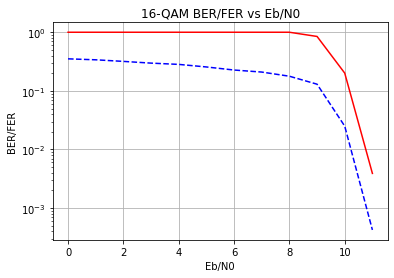

In [1]:

import sys
sys.path.insert(0, '../../build/lib')

import numpy as np
import py_aff3ct
import py_aff3ct.tools.sparse_matrix as sp
import time
import math
import matplotlib.pyplot as plt


H   = sp.alist.read("../../lib/aff3ct/conf/dec/LDPC/WIMAX_288_576.alist")
N   = H.shape[0]
m   = H.shape[1]
K   = N-m
R   = K/N
bps = 4      # Bits per Symbols   
Ns  = N//bps # Packet size in symbols
I   = 100
FE  = 1000

ebn0_min = 0
ebn0_max = 12.0
ebn0_step = 1.0

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(R)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

src  = py_aff3ct.module.source.Source_random           (K      )                                                   # Build source
enc  = py_aff3ct.module.encoder.Encoder_LDPC_from_H    (K, N, H)                                                   # Build the encoder
cstl = py_aff3ct.tools.constellation.Constellation_QAM (bps    )                                                   # Setup constellation tool
mdm  = py_aff3ct.module.modem.Modem_generic            (N, cstl)                                                   # Build the modem
chn  = py_aff3ct.module.channel.Channel_AWGN_LLR       (2*Ns   )                                                   # Build the channel (Ns complex symbols = 2Ns real dims)
dec  = py_aff3ct.module.decoder.Decoder_LDPC_BP_horizontal_layered_inter_NMS (K, N, I, H, enc.get_info_bits_pos()) # Build the decoder
mnt  = py_aff3ct.module.monitor.Monitor_BFER_AR        (K,100  )                                                   # Build the monitor (counting errors)

enc["encode       ::U_K "] = src["generate   ::U_K "   ]
mdm["modulate     ::X_N1"] = enc["encode     ::X_N "   ]
chn["add_noise    ::X_N "] = mdm["modulate   ::X_N2"   ]
mdm["demodulate   ::Y_N1"] = chn["add_noise  ::Y_N "   ]
dec["decode_siho  ::Y_N "] = mdm["demodulate ::Y_N2"   ]
mnt["check_errors ::U   "] = src["generate   ::U_K "   ]
mnt["check_errors ::V   "] = dec["decode_siho::V_K "   ]

sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
chn[ 'add_noise::CP'] = sigma
mdm['demodulate::CP'] = sigma

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

print(" Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)")
print("------------|--------------|----------|----------|------------")
for i in range(len(sigma_vals)):
	mnt.reset()
	sigma[:] = sigma_vals[i]

	t = time.time()
	while not mnt.is_done():
		src['generate'    ].exec()
		enc['encode'      ].exec()
		mdm['modulate'    ].exec()
		chn['add_noise'   ].exec()
		mdm['demodulate'  ].exec()
		dec['decode_siho' ].exec()
		mnt['check_errors'].exec()
	elapsed = time.time() - t
	total_fra = mnt.get_n_analyzed_fra()

	ber[i] = mnt.get_ber()
	fer[i] = mnt.get_fer()

	tpt = total_fra * K * 1e-6/elapsed
	print("%11.2f | %12d | %7.2e | %7.2e | %10.2f"%(ebn0[i], total_fra, ber[i], fer[i], tpt))
    

fig = plt.figure()
plt.title("16-QAM BER/FER vs Eb/N0")
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
plt.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--')
plt.show()

